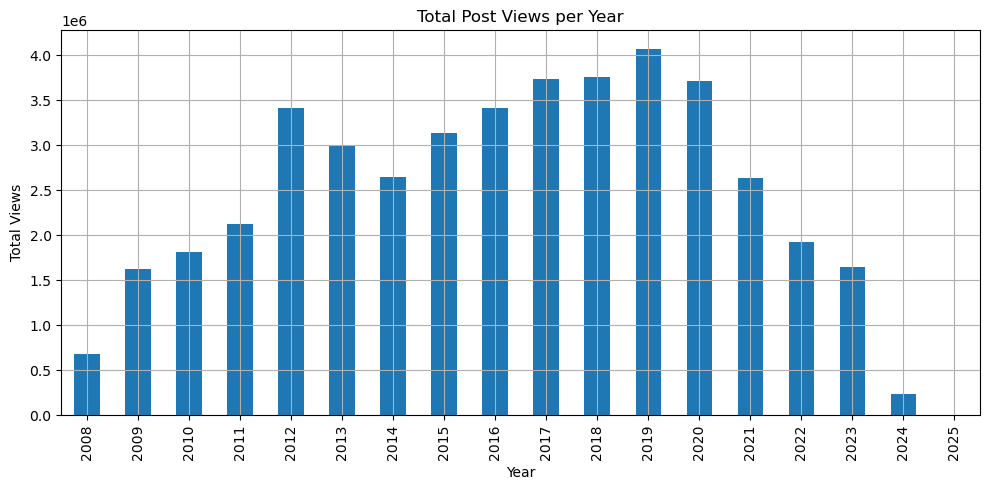

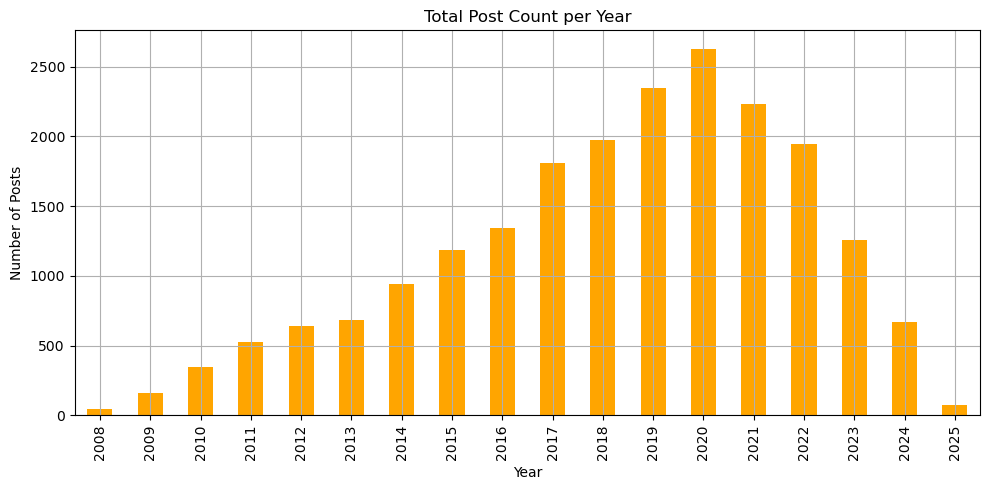

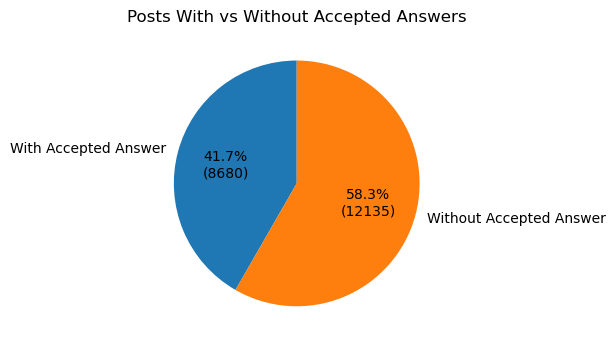

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data file
df = pd.read_csv('./data/nlp_stackoverflow_posts.csv')

# Step 1: Convert 'Creation_Date' from Unix timestamp to year
df['Year'] = pd.to_datetime(df['Creation_Date'], unit='s').dt.year

# Step 2: Group by year
views_per_year = df.groupby('Year')['View_Count'].sum()
posts_per_year = df.groupby('Year').size()

# Step 3: Plot views per year
plt.figure(figsize=(10, 5))
views_per_year.plot(kind='bar')
plt.title('Total Post Views per Year')
plt.xlabel('Year')
plt.ylabel('Total Views')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Plot post count per year
plt.figure(figsize=(10, 5))
posts_per_year.plot(kind='bar', color='orange')
plt.title('Total Post Count per Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Check for non-null values in 'Accepted_Answer'
# Count posts with and without accepted answers
has_answer = df['Accepted_Answer'].notna().sum()
no_answer = df['Accepted_Answer'].isna().sum()

# Prepare data
answer_data = pd.Series({
    'With Accepted Answer': has_answer,
    'Without Accepted Answer': no_answer
})

# Function to display percentage and count
def format_label(pct, all_vals):
    count = int(pct / 100. * sum(all_vals))
    return f'{pct:.1f}%\n({count})'

# Plot
plt.figure(figsize=(6, 6))
plt.pie(answer_data, labels=answer_data.index,
        autopct=lambda pct: format_label(pct, answer_data),
        startangle=90)
plt.title('Posts With vs Without Accepted Answers')
plt.tight_layout()
plt.show()



In [3]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

# Download necessary NLTK resources (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load data file with proper column names
df = pd.read_csv('./data/nlp_stackoverflow_posts.csv')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Standard stopwords
standard_stop_words = set(stopwords.words('english'))

def clean_text(text):
    if isinstance(text, str):
        
        # Remove inline and multiline code (common patterns)
        text = re.sub(r'```[\s\S]*?```', ' ', text)         # Markdown code blocks
        text = re.sub(r'<code>[\s\S]*?</code>', ' ', text)  # HTML code blocks
        text = re.sub(r'`[^`]*`', ' ', text)                # Inline code

        # Remove indented lines (typical code snippets)
        text = '\n'.join([line for line in text.split('\n') if not line.lstrip().startswith(('    ', '\t'))])
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
        
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()  # Keeps only visible text
        
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        
        # Remove HTML tags
        text = BeautifulSoup(text, "html.parser").get_text()
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    return ""

def lemmatize_text(text):
    word_tokens = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in word_tokens]
    return ' '.join(lemmatized_words)

def remove_standard_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in standard_stop_words]
    return ' '.join(filtered_text)

# Apply basic cleaning to your dataframe - using correct column names
df['clean_title'] = df['Title'].apply(clean_text)
df['clean_description'] = df['Description'].apply(clean_text)
df['clean_answer'] = df['Accepted_Answer'].apply(clean_text)

# Apply lemmatization 
df['lemmatized_title'] = df['clean_title'].apply(lemmatize_text)
df['lemmatized_description'] = df['clean_description'].apply(lemmatize_text)
df['lemmatized_answer'] = df['clean_answer'].apply(lemmatize_text)

# Apply standard stopword removal
df['standard_processed_title'] = df['lemmatized_title'].apply(remove_standard_stopwords)
df['standard_processed_description'] = df['lemmatized_description'].apply(remove_standard_stopwords)

# Identify domain-specific stopwords using TF-IDF
# Combine titles and descriptions for analysis
combined_texts = df['standard_processed_title'] + " " + df['standard_processed_description']

# Use TF-IDF to identify words that appear frequently across many documents
vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english') # Words appearing in >50% of docs are likely domain-specific stopwords
tfidf_matrix = vectorizer.fit_transform(combined_texts)

# Get words that have very low TF-IDF scores across many documents
feature_names = vectorizer.get_feature_names_out()
domain_specific_stopwords = set()

# Calculate average TF-IDF score for each word
avg_tfidf = tfidf_matrix.mean(axis=0).A1
word_scores = [(word, avg_tfidf[idx]) for idx, word in enumerate(feature_names)]

# Words with very high document frequency (low TF-IDF) are likely domain stopwords
sorted_word_scores = sorted(word_scores, key=lambda x: x[1])
domain_specific_stopwords = {word for word, score in sorted_word_scores[:100]}  # Take top 100 most common terms

print("Identified domain-specific stopwords:")
print(domain_specific_stopwords)

# Combine with standard stopwords
all_stopwords = standard_stop_words.union(domain_specific_stopwords)

def remove_all_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in all_stopwords]
    return ' '.join(filtered_text)

# Create fully processed versions with all stopwords (including domain-specific) removed
df['processed_title'] = df['lemmatized_title'].apply(remove_all_stopwords)
df['processed_description'] = df['lemmatized_description'].apply(remove_all_stopwords)
df['processed_answer'] = df['lemmatized_answer'].apply(remove_all_stopwords)

# Save the preprocessed dataframe
df.to_csv('./data/preprocessed_nlp_stackoverflow_data.csv', index=False)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/achaladias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/achaladias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/achaladias/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/achaladias/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/var/folders/kc/vdrqlr9x1rj06rkrzxt34zzw0000gn/T/ipykernel_59683/888452677.py:40: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


Identified domain-specific stopwords:
{'sloppy', 'oz', 'membership', 'deduplicate', 'startswith', 'grading', 'erroneously', 'conversely', 'pleased', 'trillion', 'geared', 'delivered', 'collaboration', 'tangible', 'bean', 'getattr', 'negligible', 'wrb', 'safely', 'comfort', 'chuck', 'mentor', 'columbia', 'pointless', 'lingo', 'holiday', 'yyy', 'eligible', 'wasting', 'participate', 'crm', 'featured', 'vastly', 'qualitatively', 'ecommerce', 'bid', 'uniquely', 'suspected', 'breakdown', 'competitor', 'initializer', 'federal', 'accompanying', 'declined', 'ux', 'cleanest', 'adipiscing', 'portfolio', 'responded', 'tldr', 'nthe', 'phenomenon', 'grew', 'systematically', 'mediocre', 'secret', 'stderr', 'consectetur', 'disappointment', 'tweaked', 'une', 'steadily', 'cultural', 'executor', 'wage', 'perceive', 'appeal', 'presidential', 'geforce', 'ministry', 'inclination', 'argv', 'tasked', 'feasibility', 'scarce', 'justice', 'venture', 'pursuing', 'quantum', 'fragmentation', 'oral', 'inadequate', '

Generating word cloud for titles...


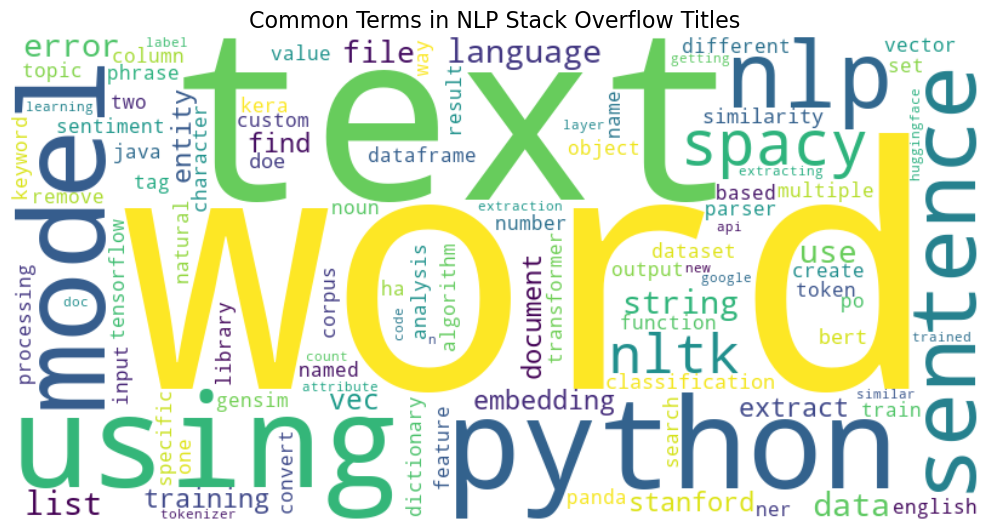

Generating word cloud for descriptions...


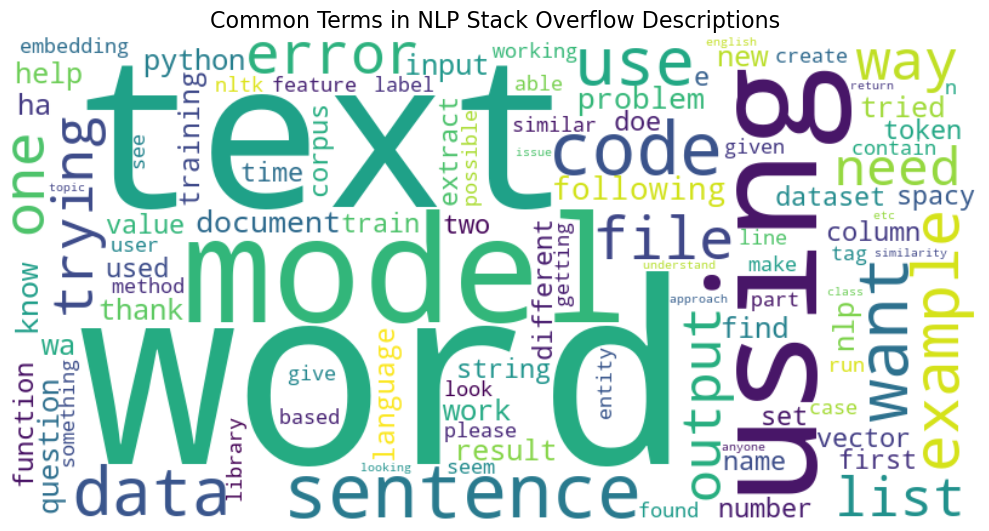

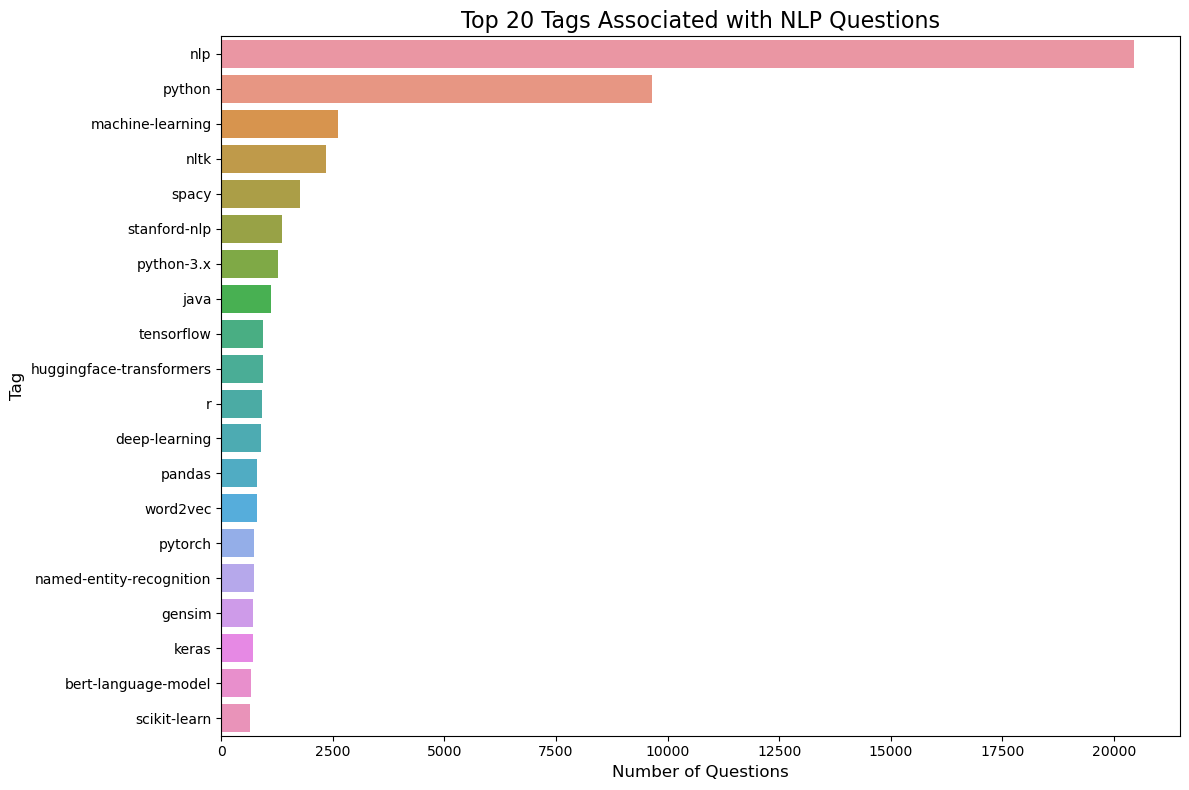

Analyzing post lengths...


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


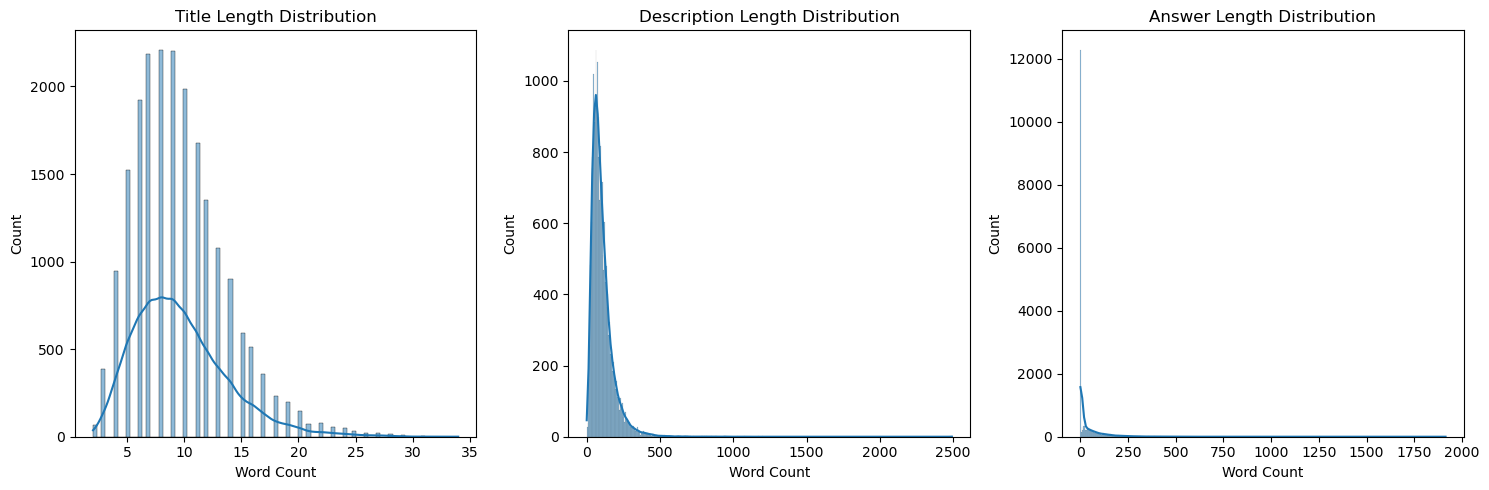

Post Length Statistics:
  Statistic  Title Length  Description Length  Answer Length
0      Mean       9.63014          104.611837      39.759272
1    Median       9.00000           85.000000       0.000000
2       Min       2.00000            0.000000       0.000000
3       Max      34.00000         2491.000000    1914.000000


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter
import re
import os

# Ensure output directory exists
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)

# Load data file with proper column names
df = pd.read_csv('./data/preprocessed_nlp_stackoverflow_data.csv')

# 1. Word Cloud Generation
def generate_wordcloud(text_series, title, filename):
    all_text = ' '.join(text_series.dropna().tolist())
    
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        max_words=100,
        collocations=False,
        contour_width=3,
        contour_color='steelblue'
    ).generate(all_text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    output_path = os.path.join(output_dir, filename)
    plt.savefig(output_path, dpi=300)
    plt.show()

print("Generating word cloud for titles...")
generate_wordcloud(df['processed_title'], 'Common Terms in NLP Stack Overflow Titles', 'title_wordcloud.png')

print("Generating word cloud for descriptions...")
generate_wordcloud(df['processed_description'], 'Common Terms in NLP Stack Overflow Descriptions', 'description_wordcloud.png')


# 2. Analyze tag distribution
def analyze_tags(df):
    all_tags = []

    for tags_str in df['Tags'].dropna():
        if isinstance(tags_str, str):
            tags = [tag.strip() for tag in tags_str.split(',') if tag.strip()]
            all_tags.extend(tags)

    tag_counter = Counter(all_tags)

    if not tag_counter:
        print("No tags found in the dataset.")
        return tag_counter

    top_tags = pd.DataFrame(tag_counter.most_common(20), columns=['Tag', 'Count'])

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count', y='Tag', data=top_tags)
    plt.title('Top 20 Tags Associated with NLP Questions', fontsize=16)
    plt.xlabel('Number of Questions', fontsize=12)
    plt.ylabel('Tag', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'top_nlp_tags.png'), dpi=300)
    plt.show()

    return tag_counter

tag_distribution = analyze_tags(df)


# 3. Analyze post lengths
def fanalyze_post_lengths(df):
    df['title_word_count'] = df['clean_title'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
    df['desc_word_count'] = df['clean_description'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
    df['answer_word_count'] = df['clean_answer'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.histplot(df['title_word_count'], kde=True)
    plt.title('Title Length Distribution')
    plt.xlabel('Word Count')
    
    plt.subplot(1, 3, 2)
    sns.histplot(df['desc_word_count'], kde=True)
    plt.title('Description Length Distribution')
    plt.xlabel('Word Count')
    
    plt.subplot(1, 3, 3)
    sns.histplot(df['answer_word_count'], kde=True)
    plt.title('Answer Length Distribution')
    plt.xlabel('Word Count')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'post_length_distributions.png'), dpi=300)
    plt.show()
    
    # Summary stats
    length_stats = pd.DataFrame({
        'Statistic': ['Mean', 'Median', 'Min', 'Max'],
        'Title Length': [
            df['title_word_count'].mean(),
            df['title_word_count'].median(),
            df['title_word_count'].min(),
            df['title_word_count'].max()
        ],
        'Description Length': [
            df['desc_word_count'].mean(),
            df['desc_word_count'].median(),
            df['desc_word_count'].min(),
            df['desc_word_count'].max()
        ],
        'Answer Length': [
            df['answer_word_count'].mean(),
            df['answer_word_count'].median(),
            df['answer_word_count'].min(),
            df['answer_word_count'].max()
        ]
    })
    
    print("Post Length Statistics:")
    print(length_stats)
    
    return length_stats

print("Analyzing post lengths...")
length_statistics = fanalyze_post_lengths(df)


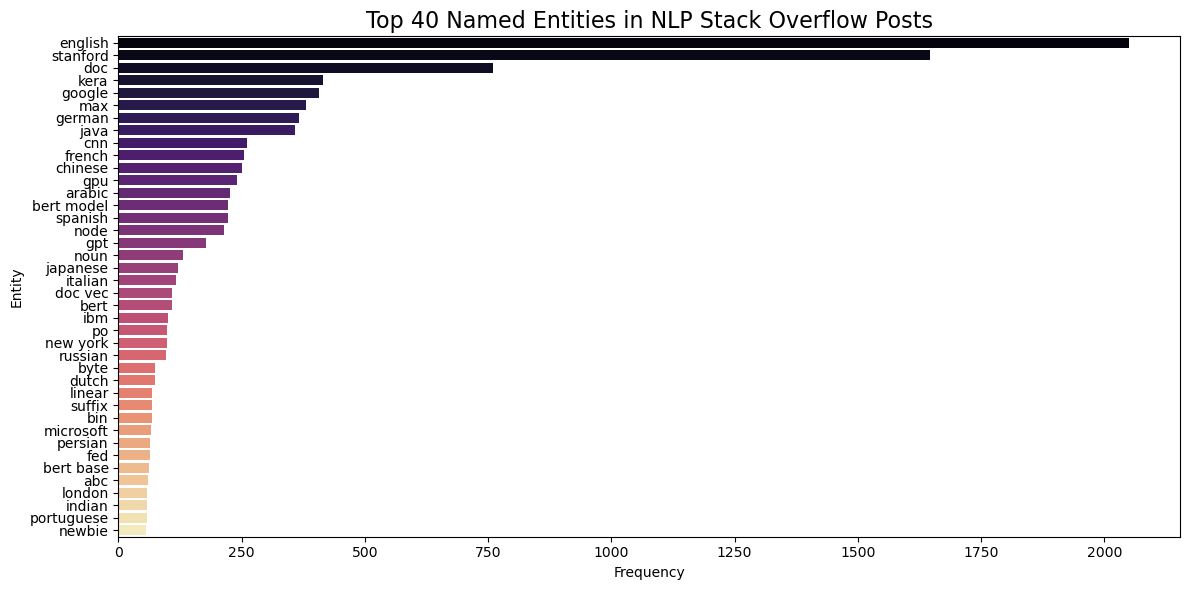

In [6]:
import spacy
from collections import Counter

# Load spaCy small English model
nlp = spacy.load("en_core_web_sm")

# Combine relevant text for NER (title + description)
df['ner_text'] = df['processed_title'].fillna('') + ' ' + df['processed_description'].fillna('')

# Extract named entities (excluding numbers/dates/etc.)
def extract_named_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ not in ['DATE', 'TIME', 'CARDINAL', 'ORDINAL', 'QUANTITY', 'PERCENT', 'MONEY']]

df['entities'] = df['ner_text'].apply(extract_named_entities)


# Flatten the entity list for all posts
all_entities = [ent for sublist in df['entities'].dropna() for ent in sublist]
entity_counts = Counter(all_entities)

# Get top 40 entities
top_entities = pd.DataFrame(entity_counts.most_common(40), columns=['Entity', 'Count'])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Entity', data=top_entities, palette='magma')
plt.title('Top 40 Named Entities in NLP Stack Overflow Posts', fontsize=16)
plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.tight_layout()
plt.savefig('./output/top_named_entities.png', dpi=300)
plt.show()




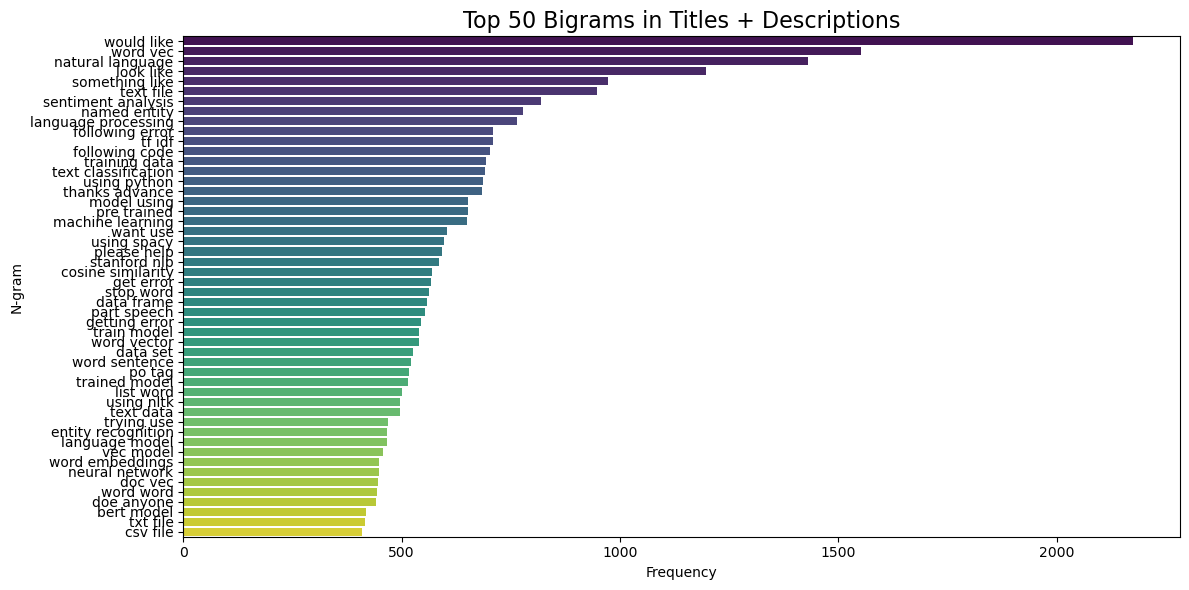

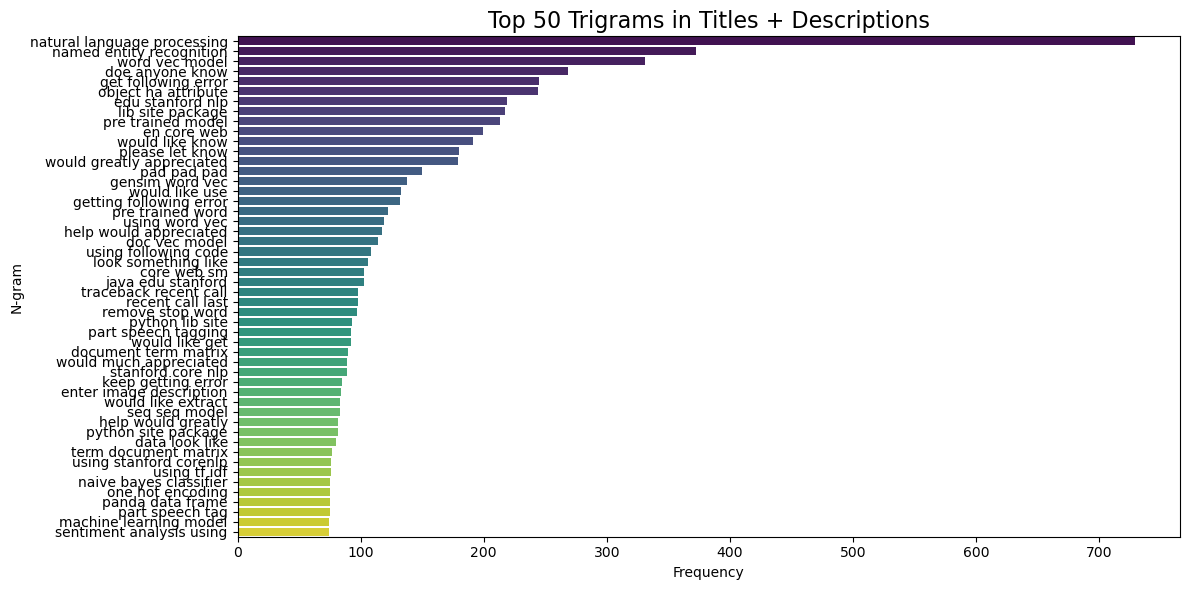

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine processed title and description
combined_texts = df['processed_title'].fillna('') + ' ' + df['processed_description'].fillna('')


def plot_top_ngrams(corpus, ngram_range=(2,2), top_n=30, title="Top N-grams"):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]
    
    ngram_df = pd.DataFrame(words_freq, columns=['N-gram', 'Count'])

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(title, fontsize=16)
    plt.xlabel("Frequency")
    plt.ylabel("N-gram")
    plt.tight_layout()
    filename = f"./output/{title.replace(' ', '_').lower()}.png"
    plt.savefig(filename, dpi=300)
    plt.show()

    
# Generate top bigrams
plot_top_ngrams(combined_texts, ngram_range=(2,2), top_n=50, title="Top 50 Bigrams in Titles + Descriptions")

# Generate top trigrams
plot_top_ngrams(combined_texts, ngram_range=(3,3), top_n=50, title="Top 50 Trigrams in Titles + Descriptions")



In [6]:
import pandas as pd
import re
import os

# Load preprocessed data
df = pd.read_csv('./data/preprocessed_nlp_stackoverflow_data.csv')

# Combine title and description for keyword matching
df['combined_text'] = df['processed_title'].fillna('') + ' ' + df['processed_description'].fillna('')

import re

sentence_patterns = {
    "Preprocessing of the text & Tokenization": [
        r'\bhow to\b (clean|remove|tokenize|preprocess)',
        r'\b(remove|strip)\b (punctuation|stopwords|tokens)',
        r'\b(preprocess|clean)\b.*\b(text|document|sentence|file)\b',
        r'\bnormalize\b.*\btext\b',
        r'\btokenize\b.*\bsentence\b',
        r'\bremove stop word\b',
        r'\bstop word\b',
        r'\btext preprocessing\b',
        r'\btext cleaning\b',
        r'\bword list\b',
        r'(?i)\btokeniz(e|ation|ing)\b',
        r'(?i)\blemmatiz(e|ation)\b',
        r'(?i)\bstemm(?:ing|er)\b',
        r'(?i)\bregular expression\b'
    ],
    "Named Entity Recognition (NER)": [
        r'\bnamed entity recognition\b',
        r'\bner\b',
        r'\bextract\b.*\b(entity|name)\b',
        r'\bspacy\b.*\bner\b',
        r'\btrain\b.*\bner\b',
        r'\bentity extraction\b',
        r'(?i)\bnamed entit(y|ies)\b'
    ],
    "Text Classification / Sentiment Analysis": [
        r'(?i)\btext classification\b',
        r'\bclassify\b.*\b(text|sentence|document)\b',
        r'(?i)\bsentiment analysis\b',
        r'\bsentiment\b.*\bclassification\b',
        r'\b(label|emotion)\b.*\b(prediction|detect|recognition)\b',
        r'\bsentiment detection\b',
    ],
    "Vectorization & Embeddings": [
        r'\b(word2vec|doc2vec|embedding|vector representation|tfidf)\b',
        r'\b(cosine|semantic) similarity\b',
        r'\bcompare\b.*\b(embedding|vector|text|code)\b',
        r'\bbert\b.*\bsimilarity\b',
        r'\bcodebert\b',
        r'\bsentence-transformer\b',
        r'\bword vec\b',
        r'\bdoc vec\b',
        r'\bvectorization\b',
        r'(?i)\bbag of words\b',
        r'(?i)\btf-?idf\b',
        r'(?i)\bembedding(s)?\b',
        r'(?i)\bone-?hot encoding\b'
        
    ],
    "Training and Model Evaluation": [
        r'\b(train|fit)\b.*\b(model|dataset)\b',
        r'\b(accuracy|loss|epoch|evaluate|evaluation|metrics|precision|recall|f1 score)\b',
        r'\bvalidation\b.*\b(result|score|metric)\b',
        r'\b(tp|fp|fn|tn)\b',
        r'\bspell correction\b.*\b(evaluate|precision|recall|f1)\b',
        r'\btraining data\b',
        r'\bpre[- ]trained model\b',
        r'\bmodel training\b',
        r'\b(entropy|cross[- ]entropy|loss function|evaluation metric)\b',
        r'\b(language model|unigram|ngram)\b.*(example|difference|train|evaluate)',
        r'\bmodel evaluation\b',
    ],
    "Parsing & POS Tagging": [
        r'\bpos tag\b',
        r'(?i)\bpart of speech\b',
        r'\b(syntax|parse)\b.*\btree\b',
        r'\bpart speech tagging\b',
        r'\bpo tag\b',
        r'\bconstituency parse\b',
        r'\bsyntax tree\b',
        r'(?i)\bdependency (parse|parser|parsing)\b',
        r'(?i)\bnoun phrase\b'
    ],
    "Coreference & Relation Extraction": [
        r'\bcoreference\b',
        r'\bcoref\b',
        r'\brelation extraction\b',
        r'\breference resolution\b',
        r'\bmention linking\b',
    ],
    "Multilingual Language Processing & Language Identification": [
        r'\bdetect\b.*\blanguage\b',
        r'\b(translate|translation)\b',
        r'\b(english|french|german|chinese|arabic|spanish|italian|portuguese|japanese|russian|multilingual)\b',
        r'\blanguage identification\b',
        r'\bnatural language processing\b',
    ],
    "Library & API Usage": [
        r'\b(use|load)\b.*\b(spacy|nltk|tensorflow|keras|transformers|openai|huggingface)\b',
        r'\bapi\b.*\b(call|request|key|token|endpoint)\b',
        r'\bhuggingface\b',
        r'\btransformers\b',
        r'\bkeras\b',
        r'\btensorflow\b',
        r'\bus(e|ing)\b.*\blibrary\b',
        r'\bnlp library\b',
        r'\bpytorch\b'
    ],
    "Dataset Preprocessing & Handling": [
        r'\b(read|load|clean)\b.*\b(file|csv|dataset|dataframe|json|xml)\b',
        r'\bdata frame\b',
        r'\bdocument\b.*\b(matrix|input)\b',
        r'\bhandling\b.*\bcolumn\b',
        r'\bcsv file\b',
        r'\bdata preprocessing\b',
    ],
    "Text Generation & LLMs": [
        r'\b(generate|completion)\b.*\btext\b',
        r'\b(language model|gpt|bert|seq2seq|chatgpt|llm)\b',
        r'\b(masked token|text generation|auto-regressive)\b',
        r'\bseq2seq\b',
        r'\blanguage model\b.*\bgeneration\b'
    ],
    "Runtime Errors & Debugging": [
        r'\berror\b',
        r'\b(traceback|exception|crash|warning|bug)\b',
        r'\bmodule not found\b',
        r'\battributeerror\b',
        r'\bkeyerror\b',
        r'\bindexerror\b',
        r'\bruntime error\b',
        r'\bget(ting)? following error\b',
        r'\bgetting error\b',
        r'\bget error\b',
        r'\bunexpected\b.*\berror\b',
        r'(?i)\berror message\b',
        r'(?i)\bhas no attribute\b',
        r'(?i)\bno module named\b'
    ],
    "General Conceptual & Understanding Questions": [
        r'\bwhat is\b.*',
        r'\bhow does\b.*\bwork\b',
        r'\bdifference between\b.*',
        r'\bwould like to know\b',
        r'\bplease help\b',
        r'\bhelp understand\b',
        r'\bexplain\b.*\bconcept\b',
        r'\bhow can\b.*',
    ]
}


def categorize_post_sentence_level(text):
    text = text.lower()
    category_scores = {}

    for category, patterns in sentence_patterns.items():
        score = 0
        for pattern in patterns:
            if re.search(pattern, text):
                score += 1
        if score > 0:
            category_scores[category] = score

    if category_scores:
        # Sort by highest match count, then by category name (to break ties)
        best_category = sorted(category_scores.items(), key=lambda x: (-x[1], x[0]))[0][0]
        return best_category
    
    return "General Conceptual & Understanding Questions"


# Apply categorization
df['category'] = df['combined_text'].apply(categorize_post_sentence_level)

# Count posts per category
category_counts = df['category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Post Count']

# Create the category output directory
category_output_dir = './categories'
os.makedirs(category_output_dir, exist_ok=True)

# Iterate over each unique category and save filtered data
for category in df['category'].unique():
    category_df = df[df['category'] == category][['Title', 'Description', 'category', 'combined_text']]
 
    # Make the filename safe (remove slashes, spaces, etc.)
    safe_category_name = re.sub(r'[^\w\s-]', '', category).replace(' ', '_')
    output_file = os.path.join(category_output_dir, f'{safe_category_name}.csv')
    
    category_df.to_csv(output_file, index=False)


# Display result
print(category_counts)


                                             Category  Post Count
0        General Conceptual & Understanding Questions        6432
1                          Runtime Errors & Debugging        2668
2                                 Library & API Usage        2026
3   Multilingual Language Processing & Language Id...        1747
4                          Vectorization & Embeddings        1489
5            Preprocessing of the text & Tokenization        1370
6                    Dataset Preprocessing & Handling        1148
7                       Training and Model Evaluation        1146
8                      Named Entity Recognition (NER)        1138
9            Text Classification / Sentiment Analysis         606
10                              Parsing & POS Tagging         520
11                             Text Generation & LLMs         413
12                  Coreference & Relation Extraction         113


<Figure size 1500x600 with 0 Axes>

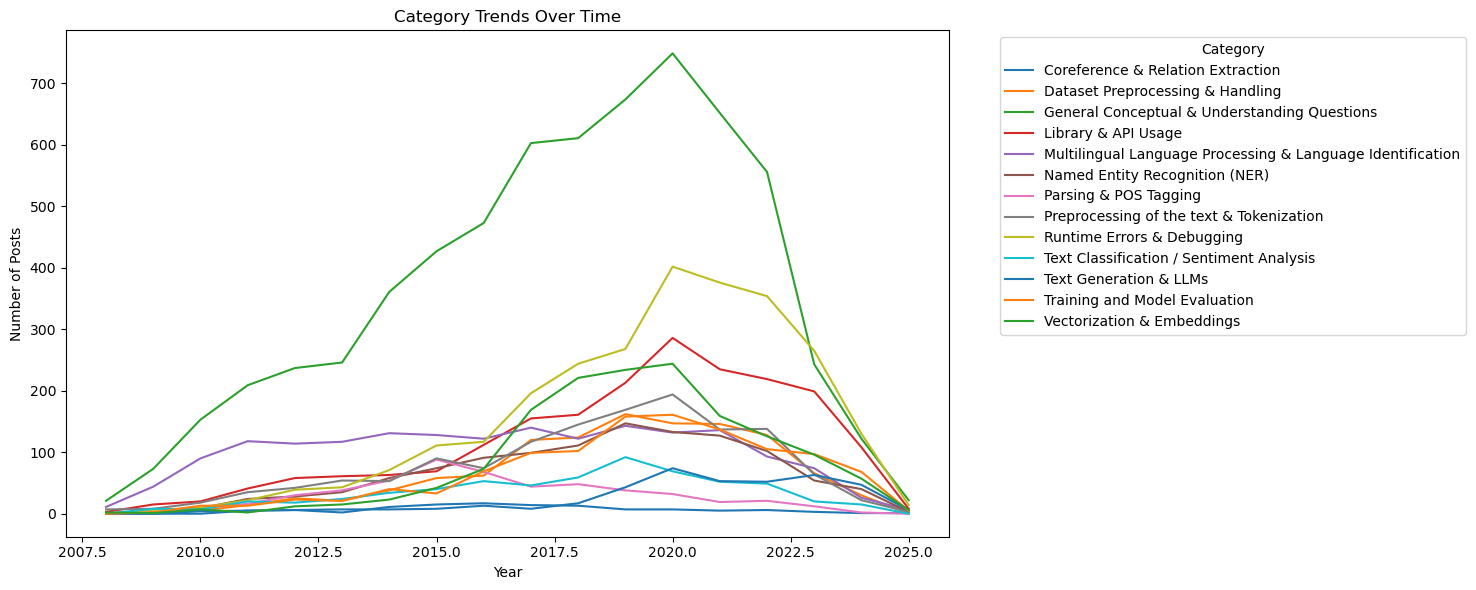

In [8]:
# Convert timestamp and group by year and category
df['Year'] = pd.to_datetime(df['Creation_Date'], unit='s').dt.year
yearly_trend = df.groupby(['Year', 'category']).size().unstack().fillna(0)

# Plot and save the figure
plt.figure(figsize=(15, 6))
yearly_trend.plot(kind='line', figsize=(15, 6))
plt.title('Category Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the chart
plt.savefig('./output/category_trends_over_time.png', dpi=300)
plt.show()